# Atomic models with ASE

abTEM uses the Atomic Simulation Environment ([ASE](https://wiki.fysik.dtu.dk/ase/)) for creating model structures. ASE is a set of tools and Python modules for setting up, manipulating, visualizing and analyzing atomistic simulations. It is also used in conjunction with other simulation codes such as GPAW for running DFT simulations. 

Here we will introduce the features of ASE needed for image simulations; please refer to the ASE documentation for a general introduction, especialy its [Building things](https://wiki.fysik.dtu.dk/ase/ase/build/build.html) page.

## Atoms
The `Atoms` object defines a collection of atoms. Here is how to set up an $\mathrm{N}_2$ molecule by directly specifying the position of the two nitrogen atoms (in units of Ångstrom):

In [1]:
from ase import Atoms
n2 = Atoms('2N', positions=[(0., 0., 0.), (0., 0., 1.10)], cell=[2, 2, 2])

abTEM uses just the positional coordinates, atomic numbers, and the unit cell properties for creating electrostatic potentials.

In [2]:
n2.positions

array([[0. , 0. , 0. ],
       [0. , 0. , 1.1]])

In [3]:
n2.numbers

array([7, 7])

In [4]:
n2.cell

Cell([2.0, 2.0, 2.0])

## Visualize

The atomic structure can be visualized inline in a Jupyter Notebook using the `show_atoms` function. This function shows a 2D projection of the structure perpendicular to the specified plane. For example:

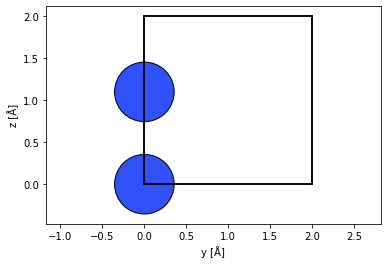

In [5]:
from abtem.visualize import show_atoms

show_atoms(n2, plane='yz');

## Molecules

More complicated molecules can also be built directly using the `molecule` object, and centered in the cell using the `center` method, with the amount of vacuum in Å given as parameter.

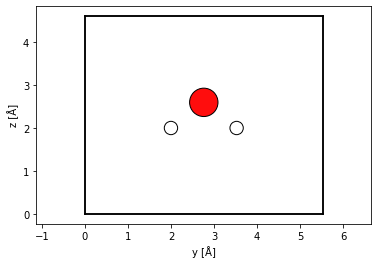

In [6]:
from ase.build import molecule
h2o = molecule('H2O')

h2o.center(2)

show_atoms(h2o, plane='yz');

Many more molecules are available via [ASE collections](https://wiki.fysik.dtu.dk/ase/ase/collections.html?highlight=collections).

## Combining atoms objects

It is trivially easy to combine atoms objects, though there is no guarantee the resulting structure is physically meaningful.

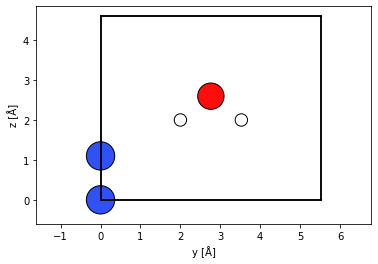

In [7]:
comb = h2o + n2

show_atoms(comb, plane='yz');

## Interactive visualization of vacuum size

In [8]:
# Interactive widgets.
import ipywidgets as widgets
import numpy as np
 
# Custom abTEM code to enable interactivity.
from abtem.visualize.interactive.artists import AtomsArtist
from abtem.visualize.interactive.canvas import Canvas
 
from ase.build import molecule
h2o = molecule('H2O')
h2o.rotate(90,'y')
 
# Canvases are layout areas where things are plotted.
canvas = Canvas(height=400, width=400)
 
# Artists do the plotting.
scale = 1400
artist = AtomsArtist(atoms=h2o, scale=scale)
canvas.artists = {'atoms': artist}
 
# Defines an interactive slider for the vacuum size.
slider = widgets.IntSlider(description='Vacuum (Å)', min=3, max=16, value=1, step=1)
 
def slider_change(*args):
    new_h2o = h2o.copy()
    new_h2o.center(slider.value)
   
    with canvas.hold_trait_notifications(): # update traits simultaneously
        canvas.x_limits = [-.1 * new_h2o.cell[0,0], new_h2o.cell[0,0] + .1 * new_h2o.cell[0,0]]
        canvas.y_limits = [-.1 * new_h2o.cell[1,1], new_h2o.cell[1,1] + .1 * new_h2o.cell[1,1]]
        area = ((canvas.y_limits[1]- canvas.y_limits[0]) * (canvas.x_limits[1]- canvas.x_limits[0]))
        artist.scale = scale / area **.8
        artist.atoms = new_h2o
   
slider.observe(slider_change, 'value')
slider_change()

canvas.x_label = 'x [Å]'
canvas.y_label = 'y [Å]'
canvas.title = 'H2O molecule in a vacuum box'

slider.layout = {'width': '400px'}

widgets.VBox([widgets.HBox([canvas.widget]), slider])

## Importing structure files

ASE can import all the common atomic structure formats, see a full list [here](https://wiki.fysik.dtu.dk/ase/ase/io/io.html). Below we import an example `.cif`-file defining a unit cell of strontium titanate (SrTiO<sub>3</sub>).

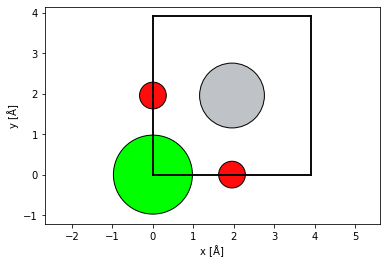

In [9]:
from ase.io import read
srtio3 = read('data/srtio3_100.cif')
show_atoms(srtio3, plane='xy');

## Manipulating structures

abTEM always assumes that the imaging electrons propagate along the $z$-axis in the direction from negative to positive coordinate values. Hence, to choose the imaging zone axis, we need to manipulate the atoms so they are properly aligned.

ASE has a range of tools for manipulating imported structures, for example, the `surface` function, which is used for creating a periodic surface (aligned with the $z$-axis) with a given set of Miller indices.

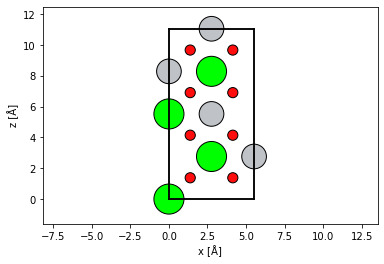

In [10]:
from ase.build import surface

srtio3_110 = surface(srtio3, indices=(1, 1, 0), layers=4, periodic=True)

show_atoms(srtio3_110, plane='xz');

In [11]:
srtio3_110.cell

Cell([5.522503961066936, 3.905, 11.04500792213387])

Simulations may require a larger crystal, to repeat the atoms by two in the $x$- and by three in the $y$-direction (but not in the $z$-direction) we can write:

In [12]:
srtio3_110 *= (2, 3, 1)

Next, we center the atoms in the cell and add 3 Å of vacuum at the entrance and exit surfaces along the $z$-axis. Note that we visualize the structure now from the side, both along the $y$ and $x$ axes.

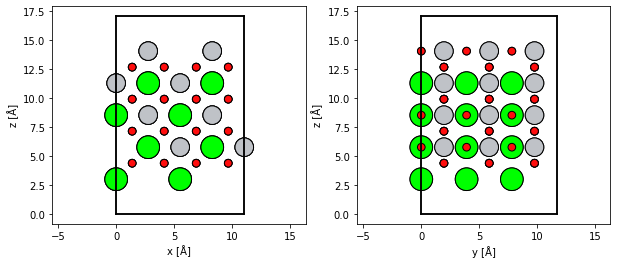

In [13]:
import matplotlib.pyplot as plt

srtio3_110.center(axis=2, vacuum=3)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
show_atoms(srtio3_110, plane='xz', ax = ax1);
show_atoms(srtio3_110, plane='yz', ax = ax2);

The manipulated structure can also be exported to disk; ASE will automatically use the file format indicated by the file ending, doing any required conversion.

In [14]:
from ase.io import write

write('data/srtio3_110_surface.cif', srtio3_110)

## Interactive example of supercell size

In [15]:
from ase.build import surface
from ase.io import read
from abtem.visualize.interactive import Canvas 
from abtem.visualize.interactive.artists import AtomsArtist
import ipywidgets as widgets
import numpy as np
from abtem.visualize.mpl import _plane2axes

srtio3 = read('data/srtio3_100.cif')

srtio3_110 = surface(srtio3, indices=(1, 1, 0), layers=4, periodic=True)

# Canvases are layout areas where things are plotted.
canvas = Canvas(height=400, width=400)
 
srtio3_110 = surface(srtio3, indices=(1, 1, 0), layers=4, periodic=True)

# Artists do the plotting.
scale = 800
artist = AtomsArtist(atoms=srtio3, scale=scale, plane='xy')
canvas.artists = {'atoms': artist}
 
# Defines an interactive slider for the H-H distances.
slider1 = widgets.IntSlider(description='x supercell', min=1, max=4, value=1, step=1)
slider2 = widgets.IntSlider(description='y supercell', min=1, max=4, value=1, step=1)
plane_dropdown = widgets.Dropdown(description='Plane', options=['xy', 'xz'], value='xy')

def slider_change(*args):
    srtio3_110 = surface(srtio3, indices=(1, 1, 0), layers=4, periodic=True) 
    srtio3_110 *= (slider1.value, slider2.value, 1)
    #srtio3_110.center(vacuum=2)
        
    with canvas.hold_trait_notifications(): # update traits simultaneously
        artist.atoms = srtio3_110
        canvas.adjust_limits_to_artists()
        
        axes = _plane2axes(artist.plane)
        x_limit = np.diag(srtio3_110.cell)[axes[0]]
        y_limit = np.diag(srtio3_110.cell)[axes[1]]
        
        canvas.x_limits = [-1.5, x_limit + 1.5]
        canvas.y_limits = [-1.0, y_limit + 1.0]
        
        area = ((canvas.y_limits[1]- canvas.y_limits[0]) * (canvas.x_limits[1]- canvas.x_limits[0]))
        artist.scale = scale / area
        
    canvas._enforce_scale_lock()

def plane_changed(*args):
    artist.plane = plane_dropdown.value
    slider_change()
    
    canvas.x_label = f'{artist.plane[0]} [Å]'
    canvas.y_label = f'{artist.plane[1]} [Å]'
        
plane_dropdown.observe(plane_changed, 'value')
slider1.observe(slider_change, 'value')
slider2.observe(slider_change, 'value')
slider_change()
plane_changed()

canvas.title = 'SrTiO3 surface supercell'

slider1.style = {'description_width': '100px'}
slider2.style = {'description_width': '100px'}
slider1.layout = {'width': '400px'}
slider2.layout = {'width': '400px'}

widgets.VBox([widgets.HBox([canvas.widget]), plane_dropdown, slider1, slider2])

## Procedural creation

ASE also includes modules for procedurally generating special structures such as [carbon nanotubes](https://wiki.fysik.dtu.dk/ase/ase/build/build.html#nanotubes) and [nanoparticles](https://wiki.fysik.dtu.dk/ase/ase/cluster/cluster.html). Here we create a chirality $(6,0)$ nanotube (`length=1` here indicates the minimal commensurate unit cell along the tube axis).

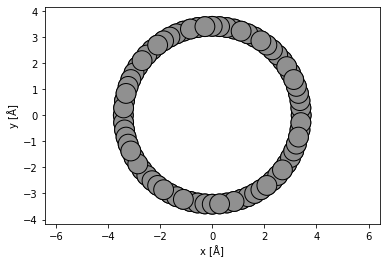

In [16]:
from ase.build import nanotube
cnt = nanotube(6, 4, length=1)

show_atoms(cnt);

As shown above, the electron propagation axis is along the length of the nanotube ($z$), which is probably not what you would like for an image simulation. To rotate the nanotube we use the ASE [rotate](https://wiki.fysik.dtu.dk/ase/ase/atoms.html?highlight=atoms#ase.Atoms.rotate) method with the angle given in degrees and the rotation axis chosen to be $x$. Note that we also want to rotate the unit cell along with the structure.

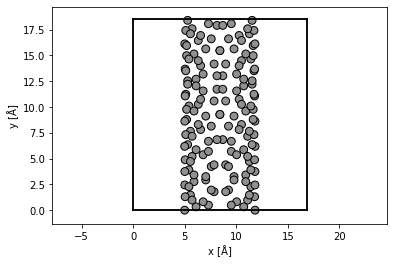

In [17]:
cnt.rotate(-90, 'x', rotate_cell=True)
cnt.center(vacuum=5, axis=(0,1))

show_atoms(cnt);

Nanoparticles can be created using the `cluster` class with objects for different crystal groups. Here, we rotate the particle for visualization purposes.

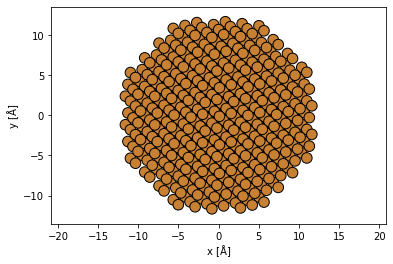

In [18]:
import ase
from ase.cluster.cubic import FaceCenteredCubic

surfaces = [(1, 0, 0), (1, 1, 0), (1, 1, 1)]
layers = [6, 9, 5]
lc = 3.61000
fcc = FaceCenteredCubic('Cu', surfaces, layers, latticeconstant=lc)

fcc.rotate(10,'y')
fcc.rotate(10,'x')

show_atoms(fcc);

The [Wulff construction](https://wiki.fysik.dtu.dk/ase/ase/cluster/cluster.html#wulff-construction) is also available via ASE.

## Interactive example of nanoparticle - Wulff Construction

In [3]:
import numpy as np
 
from nglview import ASEStructure, NGLWidget, ASETrajectory
from traitlets import HasTraits, Instance, observe
import ipywidgets as widgets
 
from ase.cluster.cubic import FaceCenteredCubic
from ase import Atoms
 
 
class AtomsView(widgets.HBox):
    atoms = Instance(Atoms)
   
    def __init__(self, atoms, width=400, height=400, **kwargs):
        self._ngl_widget = NGLWidget(ASEStructure(atoms))
        self._ngl_widget.layout.width = f'{width}px'
        self._ngl_widget.layout.height = f'{height}px'
        self._ngl_widget.add_spacefill()
        self._ngl_widget.update_spacefill(radiusType='covalent', radiusScale=1., color_scale='rainbow')
        self._ngl_widget.camera = 'orthographic'
        self._ngl_widget.parameters = { "clipDist": 0 }
        self._ngl_widget.add_unitcell()
        super().__init__(children=[self._ngl_widget], **kwargs)
   
    def center(self,*args, **kwargs):
        self._ngl_widget.center(*args, **kwargs)
   
    def get_camera_orientation(self):
        return np.array(atoms_view._ngl_widget._camera_orientation).reshape(4,4)
   
    def set_camera_orientation(self, orientation):
        self._ngl_widget._set_camera_orientation(list(np.array(orientation).flatten()))
   
    @observe('atoms')
    def _observe_atoms(self, *args):
        structure = ASEStructure(self.atoms).get_structure_string()
        structure = dict(data=structure, ext='pdb')
        self._ngl_widget._remote_call('replaceStructure', target='Widget', args=[structure])
 
def create_atoms(layers):
    surfaces = [(1, 0, 0), (1, 1, 0), (1, 1, 1)]
    lc = 3.61000
    fcc = FaceCenteredCubic('Cu', surfaces, layers, latticeconstant=lc)
    fcc.set_cell((40,40,40))
    fcc.center()
    fcc.pbc = True
    return fcc
   
atoms_view = AtomsView(create_atoms((10,15,9)))
 
slider1 = widgets.IntSlider(description='(100) layers', min=2, max=10, value=10, step=1)
slider2 = widgets.IntSlider(description='(110) layers', min=2, max=20, value=15, step=1)
slider3 = widgets.IntSlider(description='(111) layers', min=2, max=15, value=9, step=1)
 
def slider_change(*args):
    layers = [slider1.value, slider2.value, slider3.value]
    atoms_view.atoms = create_atoms(layers)
 
slider1.observe(slider_change, 'value')
slider2.observe(slider_change, 'value')
slider3.observe(slider_change, 'value')
 
app = widgets.HBox([atoms_view,
    widgets.VBox([slider1, slider2, slider3])])
 
atoms_view.center()
initial_camera_orientation = [[ 80.66476301,  -9.96646056, -34.52974435,   0.        ],
                              [  2.34274443,  86.12296529, -19.38514821,   0.        ],
                              [ 35.86286561,  16.79113119,  78.93256841,   0.        ],
                              [-20.        , -20.        , -20.        ,   1.        ]]
 
atoms_view.set_camera_orientation(initial_camera_orientation)
 
app

## Interactive example of nanoparticle - Winterbottom Construction

We have added another slider to represent the substrate wetting of the nanoparticle.

In [39]:
import numpy as np
 
from nglview import ASEStructure, NGLWidget, ASETrajectory
from traitlets import HasTraits, Instance, observe
import ipywidgets as widgets
 
from ase.cluster.cubic import FaceCenteredCubic
from ase import Atoms
 
 
class AtomsView(widgets.HBox):
    atoms = Instance(Atoms)
   
    def __init__(self, atoms, width=400, height=400, **kwargs):
        self._ngl_widget = NGLWidget(ASEStructure(atoms))
        self._ngl_widget.layout.width = f'{width}px'
        self._ngl_widget.layout.height = f'{height}px'
        self._ngl_widget.add_spacefill()
        self._ngl_widget.update_spacefill(radiusType='covalent', radiusScale=1., color_scale='rainbow')
        self._ngl_widget.camera = 'orthographic'
        self._ngl_widget.parameters = { "clipDist": 0 }
        self._ngl_widget.add_unitcell()
        super().__init__(children=[self._ngl_widget], **kwargs)
   
    def center(self,*args, **kwargs):
        self._ngl_widget.center(*args, **kwargs)
   
    def get_camera_orientation(self):
        return np.array(atoms_view._ngl_widget._camera_orientation).reshape(4,4)
   
    def set_camera_orientation(self, orientation):
        self._ngl_widget._set_camera_orientation(list(np.array(orientation).flatten()))
   
    @observe('atoms')
    def _observe_atoms(self, *args):
        structure = ASEStructure(self.atoms).get_structure_string()
        structure = dict(data=structure, ext='pdb')
        self._ngl_widget._remote_call('replaceStructure', target='Widget', args=[structure])
 
def create_atoms(layers):
    surfaces = [(1, 0, 0), (1, 1, 0), (1, 1, 1), (0, 0, 1)]
    lc = 3.61000
    fcc = FaceCenteredCubic('Cu', surfaces, layers, latticeconstant=lc)
    fcc.set_cell((40,40,40))
    fcc.center()
    fcc.pbc = True
    return fcc
   
atoms_view = AtomsView(create_atoms((10,15,9,0)))
 
slider1 = widgets.IntSlider(description='{100} layers', min=2, max=10, value=10, step=1)
slider2 = widgets.IntSlider(description='{110) layers', min=2, max=20, value=15, step=1)
slider3 = widgets.IntSlider(description='{111} layers', min=2, max=15, value=9, step=1)
slider4 = widgets.IntSlider(description='(001) substrate', min=-10, max=20, value=-1, step=1)
 
def slider_change(*args):
    layers = [slider1.value, slider2.value, slider3.value,  slider4.value]
    atoms_view.atoms = create_atoms(layers)
 
slider1.observe(slider_change, 'value')
slider2.observe(slider_change, 'value')
slider3.observe(slider_change, 'value')
slider4.observe(slider_change, 'value')
 
app = widgets.HBox([atoms_view,
    widgets.VBox([slider1, slider2, slider3, slider4])])
 
atoms_view.center()
initial_camera_orientation = [[ 100, 0, 0, 0],
                              [ 10, -20,  100, 0],
                              [ 0,  -80,  0,   0],
                              [-20, -20, -20 , 1]]
 
atoms_view.set_camera_orientation(initial_camera_orientation)
 
app

## General Bravais lattice

The ASE [lattice](https://wiki.fysik.dtu.dk/ase/ase/lattice.html) module provides a general framework for creating Atoms objects based on a Bravais lattice and a basis. Here we create a class for making graphene.

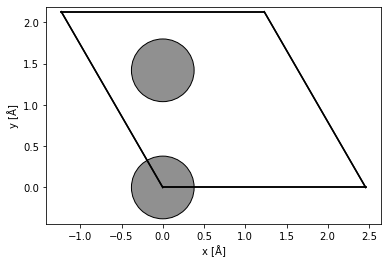

In [20]:
from ase.lattice.hexagonal import HexagonalFactory

class GrapheneFactory(HexagonalFactory):
    'A factory for creating graphene lattices.'
    xtal_name = 'graphene'
    bravais_basis = [[0, 0, 0], [1.0 / 3., 2.0 / 3.0, 0.]]

Graphene = GrapheneFactory()
graphene = Graphene('C', latticeconstant={'a' : 2.46, 'c' : 6})
graphene.center(axis=2)

show_atoms(graphene);

The minimal unit cell of graphene is hexagonal, whereas the multislice algorithm requires an orthogonal unit cell. To make the unit cell orthogonal, we can use the abTEM `orthogonalize_cell` function. It is not always possible to make a periodic cell orthogonal without introducing some strain, hence we can return the strain tensor. Hexagonal cells can be made orthogonal by doubling it size without introducing strain, hence the strain tensor is zero.

In [21]:
from abtem.structures import orthogonalize_cell

orthogonal_graphene, strain = orthogonalize_cell(graphene, return_strain=True)

print(strain)

[[0. 0.]
 [0. 0.]]


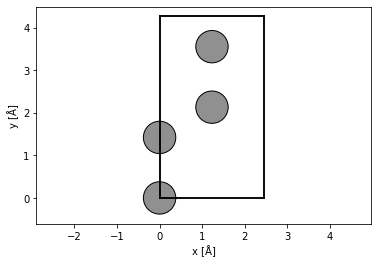

In [22]:
show_atoms(orthogonal_graphene);

Let's compare tiling the original graphene cell and tiling the orthogonal cell. 

<AxesSubplot:xlabel='x [Å]', ylabel='y [Å]'>

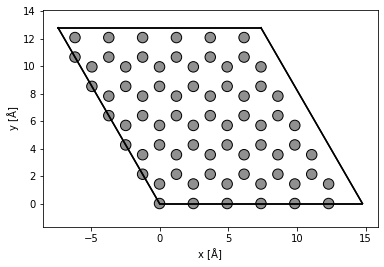

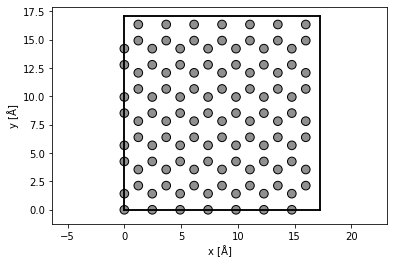

In [56]:
show_atoms(graphene*np.array((6,6,1)))
show_atoms(orthogonal_graphene*np.array((7,4,1)))

Next, we will create a class for generating another 2D material, WS2.  This time we need 2 elements, W and S.  Note that we will define only a single sheet along the z axis - if we wanted to include multiple layers along the z axis, we would need to decide on the stacking order (e.g. ABAB, ABC, etc.)

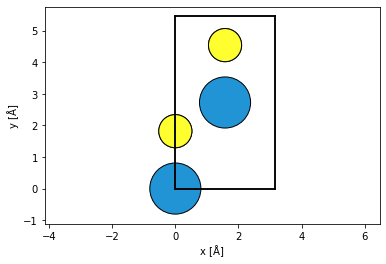

In [96]:
# The WS2 structure
class WS2Factory(HexagonalFactory):
    "A factory for creating WS2 hexagnoal lattices lattices."
    bravais_basis = [
        [0, 0, 0.5], 
        [1.0 / 3.0, 2.0 / 3.0, 0.25],
        [1.0 / 3.0, 2.0 / 3.0, 0.75],        
    ]
    element_basis = (0, 1, 1)
a_WS2 = 3.15 
c_WS2 = 12.3/2.0

# Build cell
WS2 = WS2Factory()
WS2_cell = WS2(
    ('W','S'), 
    latticeconstant={'a' : a_WS2, 'c' : c_WS2})

# Orthogonalize
WS2_orthogonal = orthogonalize_cell(WS2_cell)

# Plot the orthogonal unit cell
show_atoms(WS2_orthogonal);

Now let's build a 2D heterostructure, by stacking a WS2 layer on top of a graphene layer.

First, we need to determine an integer tiling for both cells that will produce an output with only a small amount of deformation required. We can do this by finding a good rational approximate (fractional ratio) between the unit cell dimensions.

In [140]:
denominator_limit = 10 # max value of the denominator

a0 = orthogonal_graphene.cell[0][0]
a1 = WS2_orthogonal.cell[0][0]

import fractions
r = fractions.Fraction.from_float(a0/a1).limit_denominator(denominator_limit)

# Print the result
print('A cell length ratio of ' 
     + str(np.round(a0,decimals=3))
     + ' to ' 
     + str(np.round(a1,decimals=3))
     + ' can be well-approximated by the fraction '
     + str(r)
     )

A cell length ratio of 2.46 to 3.15 can be well-approximated by the fraction 7/9


We can therefore create a heterostructure by tiling 9 graphene cells and 7 WS2 cells. We must be careful to remember to shift one of the lattices along the z axis, otherwise the atomic sheets will be directly on top of each other.

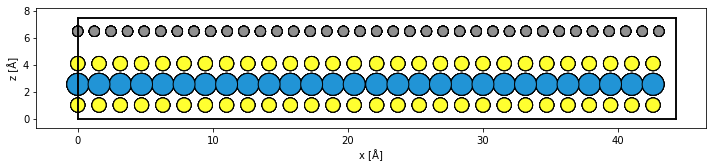

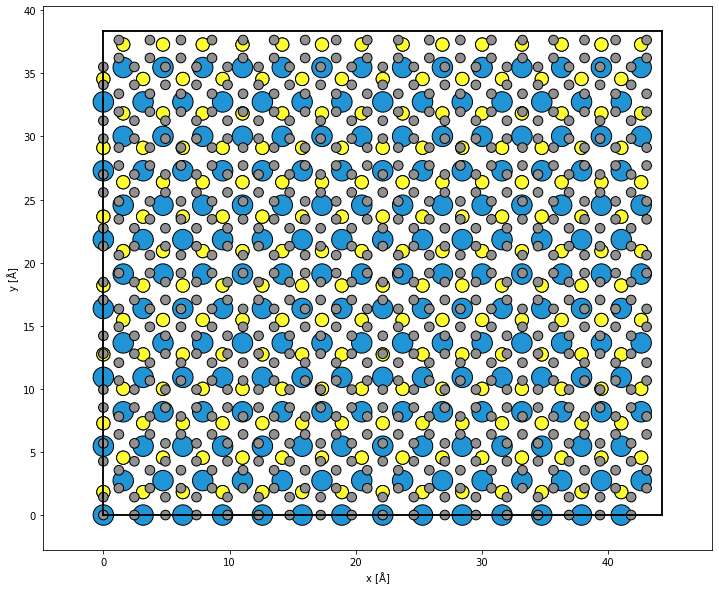

In [141]:
graphene_stack = orthogonal_graphene * (r.denominator, r.denominator, 1)
WS2_stack = WS2_orthogonal * (r.numerator, r.numerator, 1)

# shift graphene in the vertical direction
graphene_stack.translate((0, 0, 4.0))
# graphene_stack.translate((0,0, WS2_stack.cell[2][2]))

# 
heterostructure = graphene_stack + WS2_stack
heterostructure.center(axis=2, vacuum=1)


# plot the structure tiled an additonal time horizontally
show_atoms(heterostructure*(2,1,1),
          figsize=(12,2.2),
          plane='xz');
show_atoms(heterostructure*(2,1,1),
          figsize=(12,10),
          plane='xy');